In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import gc

from os import path
import sys
sys.path.append(path.abspath('..'))

In [9]:
from torchvision.datasets import MNIST
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import itertools
import operator
import pandas as pd
from tqdm.notebook import tqdm

from src.dataset import BarCodeDataset
from src.lightning_module import OCRModule
from src.augmentations import get_transforms
from src.predict_utils import matrix_to_string

from onnxruntime import InferenceSession

PosixPath('__main__')

In [15]:
DEVICE = 'cpu:0'
VOCAB = '0123456789'

In [5]:
transforms = get_transforms(
    width=416, height=96, text_size=13, vocab=VOCAB, postprocessing=True, augmentations=False
)

In [14]:
df = pd.read_csv('../data/df_valid.csv')
dataset = BarCodeDataset(df=df, data_folder='../data')
len(dataset)

81

In [17]:
model = InferenceSession('../experiments/exp1/ocr.onnx')

In [30]:
from scipy.special import softmax

In [34]:
softmax(model.run(None, {'input': [transformed_image]})[0].transpose(1, 0, 2)).argmax(axis=2)

array([[5, 7, 1, 1, 0, 0, 0, 8, 1, 1, 6, 0, 3, 0, 5, 5, 4, 1, 0, 1, 0, 2,
        2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
gt_texts = []
pr_texts = []

for i in tqdm(range(len(dataset))):
    image, text, _ = dataset[i]

    transformed_image = transforms(image=image, text='')['image']
    predict = model.run(None, {'input': [transformed_image]})[0]
    predict = torch.as_tensor(predict)
    string_pred, _ = matrix_to_string(predict, VOCAB)

    gt_texts.append(text)
    pr_texts.append(string_pred[0])

gt_texts = np.array(gt_texts)
pr_texts = np.array(pr_texts)

  0%|          | 0/81 [00:00<?, ?it/s]

In [38]:
def postprocess(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    probas = softmax(x=image.transpose(1, 0, 2))
    return probas.argmax(axis=2), probas.max(axis=2)

In [57]:
predict = model.run(None, {'input': [transformed_image]})[0]
predict.shape

(52, 1, 11)

In [58]:
labels, confidences = postprocess(predict)
labels.shape, confidences.shape

((1, 52), (1, 52))

In [59]:
labels[0].shape, confidences[0].shape

((52,), (52,))

In [62]:
import operator
import itertools

In [67]:
decode(labels, confidences)

([[5, 7, 1, 8, 1, 6, 3, 5, 4, 1, 1, 2, 3]],
 [array([0.01921977, 0.01911698, 0.01883171, 0.01921877, 0.01920629,
         0.01919772, 0.01921763, 0.01921733, 0.01919094, 0.01905772,
         0.0180833 , 0.01854636, 0.0191918 ], dtype=float32)])

In [65]:
list(itertools.groupby(zip(label, confidence), operator.itemgetter(0)))

[(5, <itertools._grouper at 0x29bfdc370>),
 (7, <itertools._grouper at 0x29bfddd50>),
 (1, <itertools._grouper at 0x29bfde320>),
 (0, <itertools._grouper at 0x29bfdd990>),
 (8, <itertools._grouper at 0x29bfdff10>),
 (1, <itertools._grouper at 0x29bfdf070>),
 (6, <itertools._grouper at 0x29bfdfdc0>),
 (0, <itertools._grouper at 0x29bfde1a0>),
 (3, <itertools._grouper at 0x29bfdd2d0>),
 (0, <itertools._grouper at 0x29bfdec20>),
 (5, <itertools._grouper at 0x29bfdd8d0>),
 (4, <itertools._grouper at 0x29bfdcb80>),
 (1, <itertools._grouper at 0x29bfdd030>),
 (0, <itertools._grouper at 0x29bfdd0c0>),
 (1, <itertools._grouper at 0x29bfdfc70>),
 (0, <itertools._grouper at 0x29bfdef80>),
 (2, <itertools._grouper at 0x29bfdc940>),
 (3, <itertools._grouper at 0x29bfde0e0>),
 (0, <itertools._grouper at 0x29bfde5f0>)]

In [23]:
print(f'accuracy = {np.mean(gt_texts == pr_texts)}')

accuracy = 0.6666666666666666


In [24]:
# ошибочные индексы
np.where(gt_texts != pr_texts)[0]

array([ 1,  5,  6,  7, 22, 24, 30, 31, 33, 34, 35, 37, 38, 42, 44, 46, 49,
       50, 52, 53, 60, 62, 64, 69, 72, 74, 75])

pred = 4607056060895
true = 4607056060895


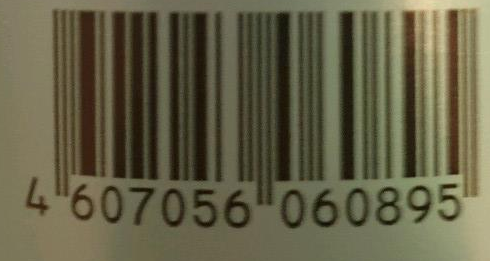

In [25]:
idx = 45
image, text, _ = dataset[idx]
print(f'pred = {pr_texts[idx]}')
print(f'true = {gt_texts[idx]}')
Image.fromarray(image)